xTrain [[-1.67705098 -1.34890655]
 [ 1.67705098 -1.34890655]
 [-1.11803399  0.79708114]
 [ 1.11803399  0.79708114]
 [ 0.55901699 -0.12262787]
 [-0.55901699 -0.73576721]
 [-0.55901699  1.41022048]
 [ 0.55901699  1.41022048]] 
xTest [[-0.55901699 -0.12262787]
 [ 0.55901699 -0.73576721]] 
yTrain [ 0.  1.  0.  1.  1.  0.  0.  1.] 
yTest [ 0.  1.]
Best hyperparameters {'n_neighbors': 1, 'weights': 'uniform'}
1.000 (+/-0.000) for {'n_neighbors': 1, 'weights': 'uniform'}
()
1.000 (+/-0.000) for {'n_neighbors': 1, 'weights': 'distance'}
()
1.000 (+/-0.000) for {'n_neighbors': 2, 'weights': 'uniform'}
()
1.000 (+/-0.000) for {'n_neighbors': 2, 'weights': 'distance'}
()
0.875 (+/-0.217) for {'n_neighbors': 3, 'weights': 'uniform'}
()
1.000 (+/-0.000) for {'n_neighbors': 3, 'weights': 'distance'}
()


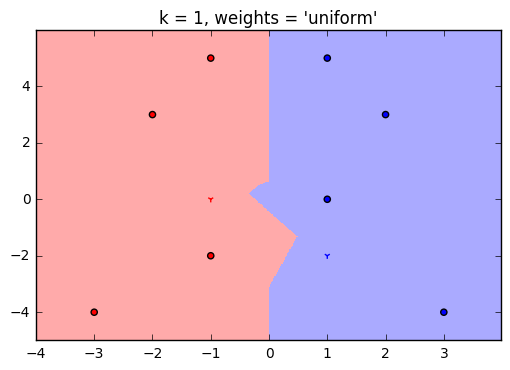

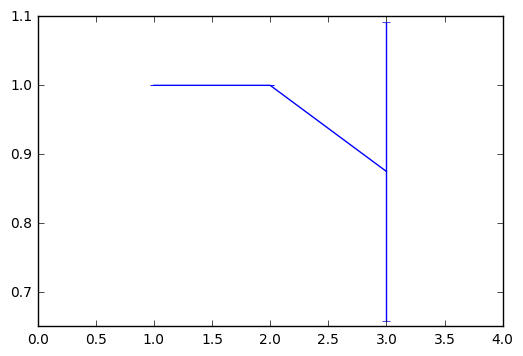

In [1]:
from sklearn import preprocessing, cross_validation, neighbors
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

datasetName = 'toyExample.data'
datasetDelimiter = ','

# load the CSV file as a numpy matrix
dataset = np.loadtxt(datasetName, delimiter=datasetDelimiter)
# separate the data from the target attributes
xRaw = dataset[:,0:dataset.shape[1]-1]
y = dataset[:,dataset.shape[1]-1]
# missing values
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
xPrep = imp.fit_transform(xRaw)
#Standardize data
scaler = preprocessing.StandardScaler().fit(xPrep)
x=scaler.transform(xPrep)

#Divide in training and test, shuffling the examples and keeping the proportion of examples of each class
xTrain, xTest, yTrain, yTest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=0)
print 'xTrain', xTrain, "\nxTest", xTest, "\nyTrain", yTrain, "\nyTest", yTest


#Generate the mesh
h = .02  # step size in the mesh
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min = scaler.inverse_transform(xTrain)[:, 0].min() - 1
x_max = scaler.inverse_transform(xTrain)[:, 0].max() + 1
y_min = scaler.inverse_transform(xTrain)[:, 1].min() - 1
y_max = scaler.inverse_transform(xTrain)[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


################################################################
#KNN results
################################################################

#Generate grid search
hyperParams = {'n_neighbors': range(1,4), 
               'weights': ['uniform', 'distance']}

#Create an instance of Neighbors Classifier and fit the data for the grid parameters
modelCV = GridSearchCV(neighbors.KNeighborsClassifier(), 
                     hyperParams, cv=4, scoring='accuracy')
modelCV.fit(xTrain, yTrain)
print "Best hyperparameters", modelCV.best_params_
neighList, errList, devList = [], [], []
for hyperP, mean_score, scores in modelCV.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std(), hyperP))
    if hyperP['weights'] == modelCV.best_params_['weights']:
        neighList.append(hyperP['n_neighbors'])
        errList.append(mean_score)
        devList.append(scores.std())
    print()


#Create an instance of Neighbors Classifier with the best hyperparameters and the full training set
model = neighbors.KNeighborsClassifier(n_neighbors = modelCV.best_params_['n_neighbors'], 
                                       weights = modelCV.best_params_['weights'])
model.fit(xTrain, yTrain)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


# Plot also the training points
plt.scatter(scaler.inverse_transform(xTrain)[:, 0], 
            scaler.inverse_transform(xTrain)[:, 1], 
            c=yTrain, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("k = %i, weights = '%s'"
          % (modelCV.best_params_['n_neighbors'], modelCV.best_params_['weights']))


#Saving and re-loading the model
joblib.dump(model, 'KNN_model.pkl') 
newModel = joblib.load('KNN_model.pkl')
newModel.predict(xTest)
plt.scatter(scaler.inverse_transform(xTest)[:, 0], 
                scaler.inverse_transform(xTest)[:, 1], 
                c=yTest, cmap=cmap_bold, marker = '1')

plt.show()
plt.errorbar(neighList, errList, yerr = devList)
plt.xlim(neighList[0]-1, neighList[len(neighList)-1]+1)
plt.show()

